## **Librerías**

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.options.display.max_columns = False

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append('./')
sys.path.append('../')

In [4]:
import Utils.consultas_mysql as cst

## **Business Case**

### **1.	¿Cuántos usuarios hay registrados?**

In [10]:
query = '''
SELECT 
    COUNT(*) AS TOTAL,
    COUNT(DISTINCT USER_ID) AS USER_IDS,
    COUNT(DISTINCT USER_MAIL) AS USER_MAILS,
    COUNT(DISTINCT USER_PHONE) AS USER_PHONES
FROM TBL_DIM_USERS
'''

df_distincts = cst.get_data(query)

In [11]:
df_distincts

,TOTAL,USER_IDS,USER_MAILS,USER_PHONES
0,30000,25904,9481,29980


En la tabla hay un total de **30.000 usuarios**, sin embargo El número total de usuarios registrados en la base de datos es de 30,000. Sin embargo, al analizar los campos clave, encontramos las siguientes diferencias:

- Usuarios únicos por ID **(USER_ID/CODE)**: Existen **25,904** identificadores de usuario distintos.
- Usuarios únicos por correo electrónico **(USER_MAIL)**: Se registraron 9,481 correos electrónicos únicos.
- Usuarios únicos por número de teléfono **(USER_PHONE)**: Hay **29,980** números de teléfono únicos registrados.

Estos resultados sugieren que hay registros repetidos o múltiples formas de identificación asociadas a un mismo usuario en términos de correo electrónico y teléfono. Esto puede indicar usuarios que tienen múltiples direcciones de correo o números de teléfono asociados en el sistema.

In [12]:
query = '''
SELECT 
    USER_ID,
    USER_MAIL,
    USER_PHONE
FROM TBL_DIM_USERS
GROUP BY 
    USER_ID,
    USER_MAIL,
    USER_PHONE
'''

df_group_users = cst.get_data(query)

In [ ]:
df_group_users

,USER_ID,USER_MAIL,USER_PHONE
0,98631,user-9863@mail.com,7462446
1,94525,user-9452@mail.com,39163015
2,76735,user-7673@mail.com,73427742
3,100,user-10@mail.com,49649666
4,70297,user-7029@mail.com,27965110
...,...,...,...
29995,38302,user-3830@mail.com,39561210
29996,5433,user-543@mail.com,11264348
29997,12259,user-1225@mail.com,37638115
29998,44998,user-4499@mail.com,54397533


### **2.	¿Cuántas propiedades hay por cada usuario?**

In [35]:
query = '''
    WITH
        BASE AS(
            SELECT 
                USER_ID,
                COUNT(*) AS CANT_PROPERTIES
            FROM TBL_FCT_PROPERTIES
            GROUP BY USER_ID
        )

    SELECT 
        CANT_PROPERTIES,
        COUNT(*) AS USERS
    FROM BASE
    GROUP BY CANT_PROPERTIES
    ORDER BY 2 DESC
'''

df_users_properties = cst.get_data(query)

In [45]:
df_users_properties['%'] = df_users_properties['USERS'].apply(
    lambda x: 
        x/df_users_properties['USERS'].sum()*100
    )
df_users_properties

,CANT_PROPERTIES,USERS,%
0,1,22175,85.604540
1,2,3383,13.059759
2,3,327,1.262353
3,4,17,0.065627
4,5,2,0.007721


En la base de datos, la distribución de propiedades por usuario es la siguiente:

- 22,175 usuarios tienen 1 propiedad (85.6%).
- 3,383 usuarios tienen 2 propiedades (13%).
- 327 usuarios tienen 3 propiedades (1.2%).
- 17 usuarios tienen 4 propiedades (0.06%).
- 2 usuarios tienen 5 propiedades (0.007%).

Esto refleja cómo están distribuidas las propiedades entre los usuarios en la plataforma.

### **3.	¿Cuántas casas y cuántos departamentos hay por estado?**

In [ ]:
query = '''
    SELECT 
        STATE,
        TYPE,
        COUNT(*) AS TOTAL_PROPERTIES
    FROM TBL_FCT_PROPERTIES
    GROUP BY 
        STATE,
        TYPE
    ORDER BY 3 DESC
'''

df_state_type = cst.get_data(query)

In [98]:
# Identificamos los estados con la mayor cantidad de propiedades
df_states = df_state_type.groupby('STATE')[['TOTAL_PROPERTIES']].sum().reset_index().sort_values(
    'TOTAL_PROPERTIES', 
    ascending=False
)

df_top_state = df_states.head(5).copy().reset_index(drop=True,)

In [99]:
df_top_state_type = pd.merge(
    df_top_state,
    df_state_type,
    how='left',
    left_on='STATE',
    right_on='STATE'
)

In [111]:
df_top_state_type.rename(columns={
    'TOTAL_PROPERTIES_x': 'Total_By_State',
    'TOTAL_PROPERTIES_y': 'Total_By_Type'
}, inplace=True)

In [129]:
df_top_state_type.drop('%By_State', axis=1)

,STATE,Total_By_State,TYPE,Total_By_Type
0,DF / CDMX,6441,Casa,5043
1,DF / CDMX,6441,Departamento,1398
2,Yucatán,3262,Departamento,2106
3,Yucatán,3262,Casa,1156
4,México,2771,Departamento,1853
5,México,2771,Casa,918
6,Querétaro,2590,Departamento,1728
7,Querétaro,2590,Casa,862
8,Quintana Roo,2586,Casa,2049
9,Quintana Roo,2586,Departamento,537


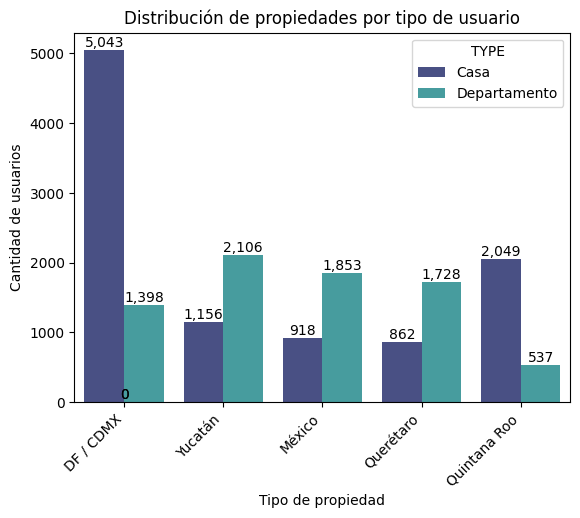

In [ ]:
ax = sns.barplot(
        data=df_top_state_type, 
        x="STATE", 
        y="Total_By_Type", 
        hue="TYPE", 
        palette="mako"
)

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')


plt.title('Distribución de propiedades por tipo de usuario')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Cantidad de usuarios')

plt.show()

En el gráfico se evidencia la cantidad de casas y departamentos por estado, considerando solo el top 5 de estados por simplicidad del ejercicio:

- **DF / CDMX** tiene un total de 6,441 inmuebles, de los cuales 5,043 son casas y 1,398 son departamentos.
- **Yucatán** tiene un total de 3,262 inmuebles, con 1,156 casas y 2,106 departamentos.
- **México** cuenta con 2,771 inmuebles, distribuidos en 918 casas y 1,853 departamentos.
- **Querétaro** tiene un total de 2,590 inmuebles, con 862 casas y 1,728 departamentos.
- **Quintana Roo** tiene 2,586 inmuebles, de los cuales 2,049 son casas y 537 son departamentos.


### **4.	¿Tenemos códigos duplicados? ¿Por qué?**


In [115]:
query = '''
    SELECT 
        COUNT(USER_ID) AS RECORDS,
        COUNT(DISTINCT USER_ID) AS DISTINCT_RECORDS
    FROM TBL_FCT_PROPERTIES
'''

df_records = cst.get_data(query)

In [116]:
df_records

,RECORDS,DISTINCT_RECORDS
0,30000,25904


In [ ]:
query = '''
SELECT *
FROM TBL_DIM_USERS
'''

df_users = cst.get_data(query)

In [122]:
df_code_users = df_users.groupby('USER_ID').count().reset_index()

In [125]:
df_code_users.sort_values('USER_PHONE', ascending=False)

,USER_ID,USER_MAIL,USER_PHONE
2639,10202,5,5
18076,70113,5,5
1039,4019,4,4
6127,23573,4,4
10008,38421,4,4
...,...,...,...
43,215,1,1
2198,8489,1,1
45,218,1,1
46,219,1,1


In [126]:
df_users.query('USER_ID == 10202')

,USER_ID,USER_MAIL,USER_PHONE
3135,10202,user-1020@mail.com,98257517
8654,10202,user-1020@mail.com,7898338
14119,10202,user-1020@mail.com,20054586
22889,10202,user-1020@mail.com,30349147
27174,10202,user-1020@mail.com,43360569


In [127]:
df_users.query('USER_ID == 70113')

,USER_ID,USER_MAIL,USER_PHONE
5162,70113,user-7011@mail.com,84883146
9798,70113,user-7011@mail.com,92052339
11167,70113,user-7011@mail.com,23568485
16855,70113,user-7011@mail.com,28288272
18531,70113,user-7011@mail.com,75427122


Se han detectado valores repetidos en los códigos dentro de la base de datos. Durante la validación, hemos encontrado que esto ocurre cuando los usuarios tienen más de un correo electrónico, más de un número de teléfono de contacto, o incluso diferentes propiedades. La plataforma registra esta información creando un nuevo registro, pero conserva el mismo código.